# Data visualization

In this notebook, we create sample visualizations of our data to show examples of the usage of data science tools to performance analysis in HPC.

## Import packages

Most of our data wrangling is done with `polars`  
We use `matplotlib` to create our plots.

In [1]:
import polars as pl
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

We define a custom color map to be used in some figures

In [2]:
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("my_cmap", ["#ffffff", "#ff0000"])

## Data reading

We read our data and clean up the data set

In [3]:
df = pl.read_parquet("output_80_greedylb_196761.pq", columns=["Parent", "Start", "End", "Duration", "Value"])
df = df.drop_nulls()
for col in df.iter_columns():
    col = col.str.strip_chars()
    if col.name == "Parent":
        col = col.str.replace(r"^pe", "").cast(pl.Int32)
    elif col.name != "Value":
        col = col.cast(pl.Float32)
    df = df.with_columns(col)
df = df.rename({"Value": "Chare", "Parent": "Processing Element"})

## Chare frequency chart
In this section we show a chart of the frequency of chares in this execution of the simulation.

In [4]:
frequency_df = df.group_by("Chare").agg(pl.len()).sort(by="len")

Text(0.5, 0, 'Frequency')

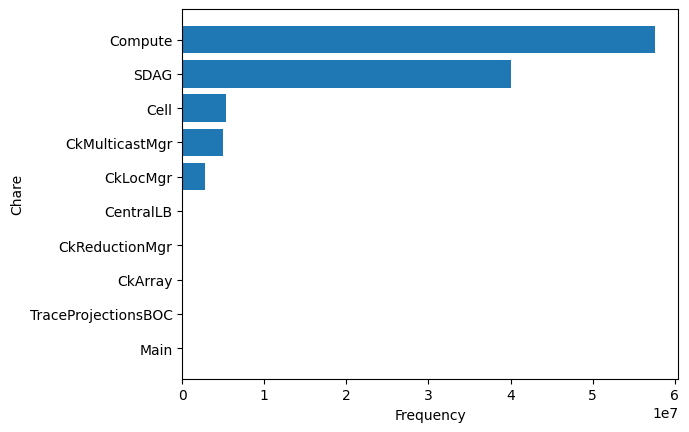

In [5]:
fig, ax = plt.subplots()
ax.barh(y=frequency_df["Chare"], width=frequency_df["len"])
ax.set_ylabel("Chare")
ax.set_xlabel("Frequency")
# ax.set_title("Frequency of Chare execution across all Processing Elements")

## Duration of each chare across all Processing Elements

In [6]:
durations_df = df.group_by("Chare").agg(pl.sum("Duration")).sort(by="Duration")

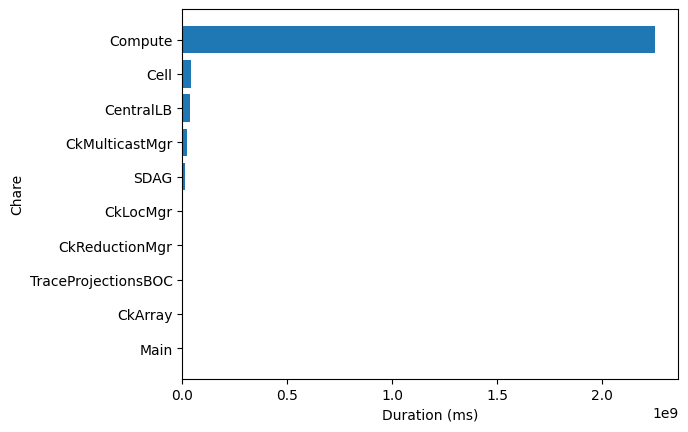

In [7]:
fig, ax = plt.subplots()
ax.barh(y=durations_df["Chare"], width=durations_df["Duration"])
ax.set_ylabel("Chare")
ax.set_xlabel("Duration (ms)")
# ax.set_title("Duration of Chare execution across all Processing Elements")
fig.savefig("duration_chart.png")

## Gantt chart

In [ ]:
df_computes = df.filter(pl.col("Chare")=="Compute")

In [ ]:
fig, ax = plt.subplots()

In [ ]:
for row in df_computes.iter_rows():
    ax.barh(
        y=row[4],
        width=row[3],
        left=row[1],
        height=0.4,
        color='skyblue',
        edgecolor='black'
    )
    # ax.text(row['Start'], pe_to_y[row['Processing Element']] + 0.1, row['Chare'], fontsize=8)


## Chare activity per Processing Element heatmap

In [8]:
agg_pe_chare_df = df.group_by(["Processing Element", "Chare"]).\
    agg(pl.sum("Duration") * 0.001).\
        sort(["Processing Element", "Duration"])

In [9]:
heatmap_pe_chare_df = agg_pe_chare_df.pivot(index="Processing Element", on="Chare", values="Duration")
heatmap_pe_chare_df = heatmap_pe_chare_df.drop("Processing Element") # This gets added as a column after the pivot, but we don't need it

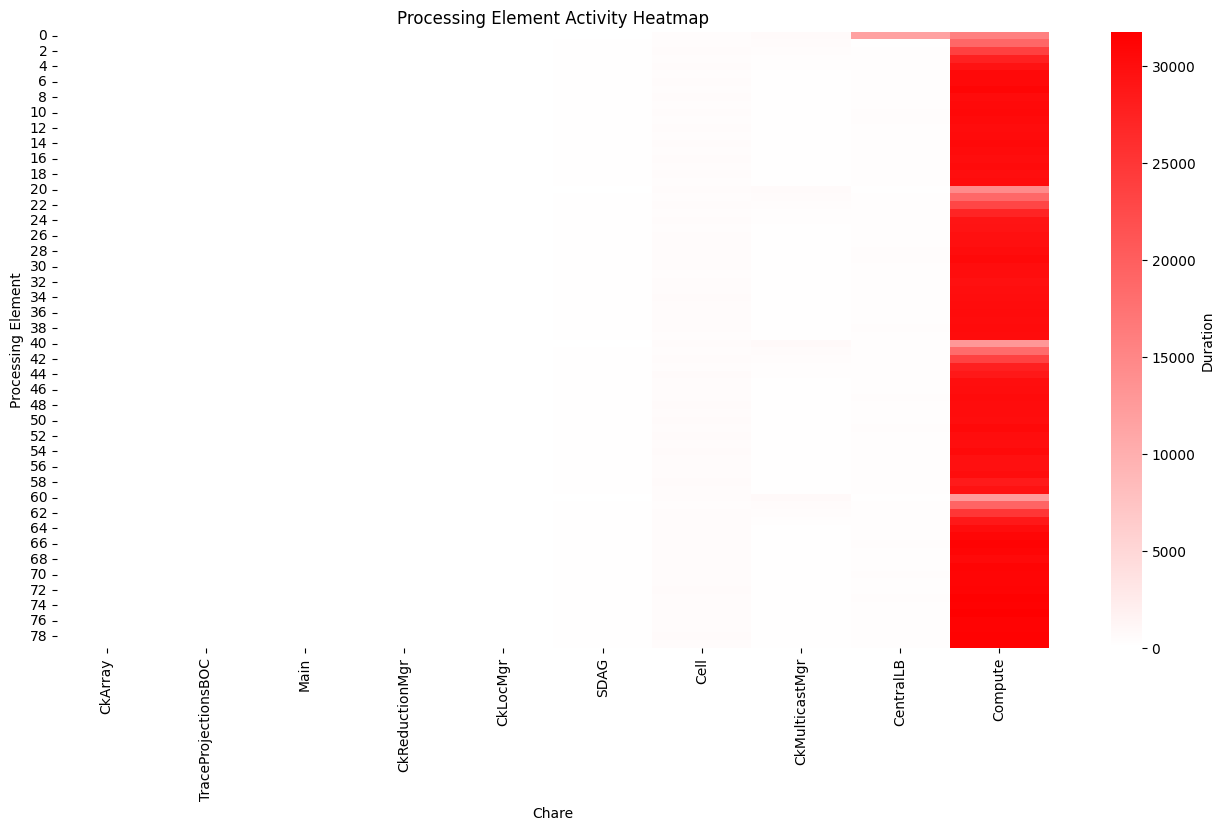

In [10]:
fig = plt.figure(figsize=(16, 8))
ax = sns.heatmap(
    heatmap_pe_chare_df,
    cmap=custom_cmap,
    # cmap=custom_cmap,  # or "magma", "coolwarm", etc.
    cbar_kws={'label': 'Duration'},
    linecolor='none',
    xticklabels=heatmap_pe_chare_df.columns
)
ax.set_title("Processing Element Activity Heatmap")
ax.set_xlabel("Chare")
ax.set_ylabel("Processing Element")
fig.savefig("Output.png")

## Processing Element Activity across time

In [11]:
bin_size = 1_000_000.0

condition = pl.when(pl.col("Start") // bin_size != pl.col("End") // bin_size)
binned_df = df.with_columns([
    (pl.col("Start") // bin_size).cast(pl.Int32).alias("Time Bin Start"),
    (pl.col("End") // bin_size).cast(pl.Int32).alias("Time Bin End"),
    condition.then(pl.col.Duration - (pl.col.End % bin_size)).otherwise(pl.col("Duration")).alias("Start Bin Duration"), # If the bins are different, then it means that there is spill over and we must divide the duration across the bins
    condition.then(pl.col.End % bin_size).otherwise(-1).cast(pl.Int32).alias("End Bin Duration"), # We set the "End Bin Duration" as -1 if there's no spill over so we can easily drop it later
]).drop(pl.col("Start"), pl.col("End"), pl.col("Duration"))
binned_df = binned_df.\
    unpivot(on=["Start Bin Duration", "End Bin Duration"], # We melt the dataframe and create a row for each Bin Duration Type
            variable_name="Bin Duration Type", 
            value_name="Bin Duration",
            index=["Processing Element", "Chare", "Time Bin Start", "Time Bin End"])
binned_df = binned_df.remove( # We remove the entries where there was no spillover
    (pl.col("Bin Duration") == -1) &
    (pl.col("Bin Duration Type") == "End Bin Duration")
)
binned_df = binned_df.select([
    pl.col("Processing Element"),
    pl.col("Chare"),
    pl.when(
        (pl.col("Time Bin Start") != pl.col("Time Bin End")) &
        (pl.col("Bin Duration Type") == "Start Bin Duration")
    ).then(-1).otherwise(pl.col("Time Bin Start")).alias("Time Bin Start"), # If the time bins are different, but this is a start bin then this is a duplicate and we mark it for deletion
    pl.when(
        (pl.col("Time Bin Start") == pl.col("Time Bin End")) &
        (pl.col("Bin Duration Type") == "End Bin Duration")
    ).then(-1).otherwise(pl.col("Time Bin End")).alias("Time Bin End"), # If the time bins are the same, but this is an end bin then this is a duplicate and we mark it for deletion
    pl.col("Bin Duration Type"),
    pl.col("Bin Duration")
])
binned_df = binned_df.remove( # We delete the marked rows
    (pl.col("Time Bin Start") == -1) |
    (pl.col("Time Bin End") == -1)
)
binned_df = binned_df.select([ # Finall we take either the Start or End time bin depending on which one the entry actually belongs to
    (pl.col("Processing Element")),
    (pl.col("Chare")),
    pl.when(
        (pl.col("Bin Duration Type") == "Start Bin Duration")
    ).then(pl.col("Time Bin Start")).otherwise(pl.col("Time Bin End")).alias("Time Bin"),
    (pl.col("Bin Duration").alias("Duration"))
    ])

In [12]:
agg_df = binned_df.group_by(["Processing Element", "Time Bin"]).\
    agg(pl.sum("Duration") * 0.001).\
        sort(["Processing Element", "Time Bin"])

In [13]:
heatmap_df = agg_df.pivot(index="Processing Element", on="Time Bin", values="Duration")

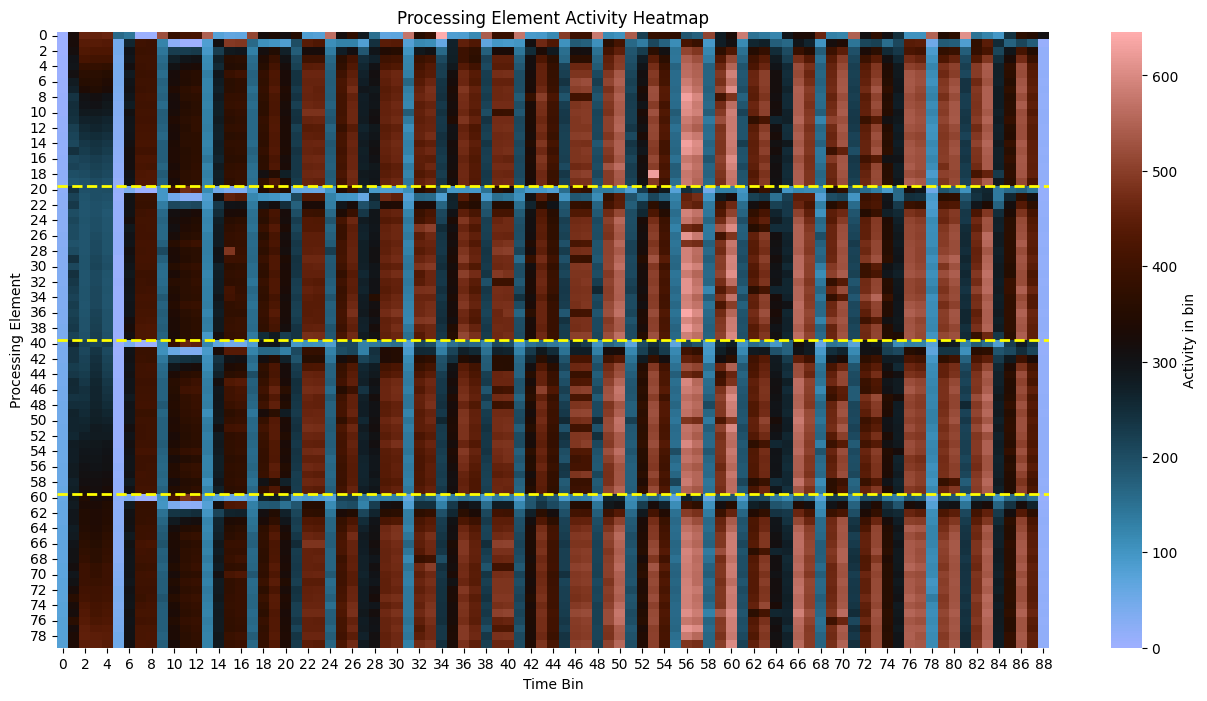

In [14]:
import seaborn as sns
fig = plt.figure(figsize=(16, 8))
ax = sns.heatmap(
    heatmap_df,
    # cmap=custom_cmap,
    cmap="berlin",
    cbar_kws={'label': 'Activity in bin'},
    linecolor='none'
)
ax.axhline(20, color='yellow', linestyle='--', linewidth=2) # Line at y=1
ax.axhline(40, color='yellow', linestyle='--', linewidth=2) # Line at y=1
ax.axhline(60, color='yellow', linestyle='--', linewidth=2) # Line at y=1

# ax.axhline(3, color='green', linestyle=':', linewidth=2) # Line at y=3
ax.set_title("Processing Element Activity Heatmap")
ax.set_xlabel("Time Bin")
ax.set_ylabel("Processing Element")
fig.savefig("Output.png")

## Imbalance Heatmap